Notebook for umap

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [32]:
df = pd.read_parquet("freMTPL2freq.parquet")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678007 non-null  float64
 1   Exposure    678007 non-null  float64
 2   Area        678007 non-null  object 
 3   VehPower    678007 non-null  int32  
 4   VehAge      678007 non-null  int32  
 5   DrivAge     678007 non-null  int32  
 6   BonusMalus  678007 non-null  int32  
 7   VehBrand    678007 non-null  object 
 8   VehGas      678007 non-null  object 
 9   Density     678007 non-null  int32  
 10  Region      678007 non-null  object 
 11  ClaimTotal  678007 non-null  float64
 12  ClaimNb     678007 non-null  float64
 13  LearnTest   678007 non-null  object 
dtypes: float64(4), int32(5), object(5)
memory usage: 59.5+ MB
None


,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


In [33]:
# Create summary table grouped by number of claims
summary = df.groupby('ClaimNb').agg({
    'Exposure': 'sum', 'ClaimNb': 'count'
}).rename(columns={'ClaimNb': 'Count'})

print("Summary by Number of Claims:")
print(summary)

Summary by Number of Claims:
              Exposure   Count
ClaimNb                       
0.0      341089.647202  653069
1.0       16314.864562   23571
2.0         908.853699    1298
3.0          42.370000      62
4.0           1.990000       5
5.0           1.080000       2


A lot of rows have zero claims

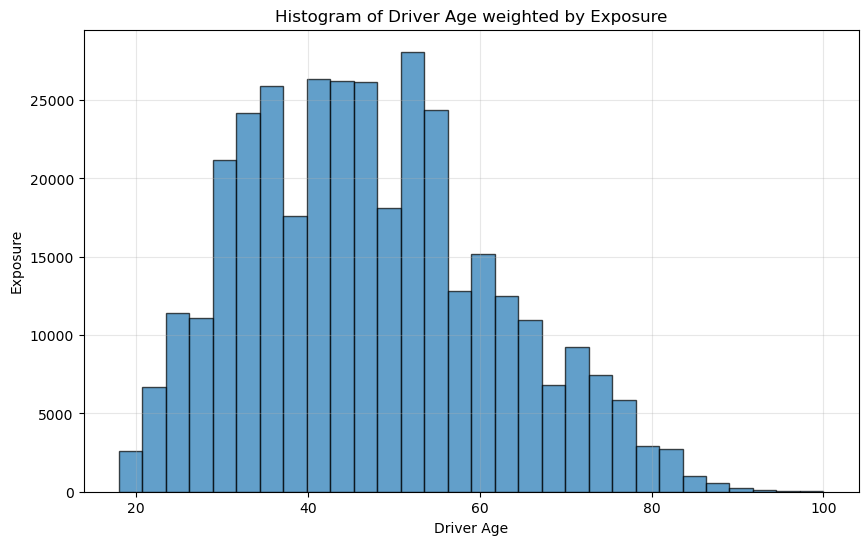

In [34]:
# Create histogram of DrivAge weighted by Exposure
plt.figure(figsize=(10, 6))
plt.hist(df['DrivAge'], weights=df['Exposure'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Driver Age')
plt.ylabel('Exposure')
plt.title('Histogram of Driver Age weighted by Exposure')
plt.grid(True, alpha=0.3)
plt.show()

The general goal of actuaries is to accurately predict (forecast) the (future) claims frequencies, To account for the different time exposures, one studies the claims frequencies Yi = Ni/vi.

First start with unsupervised learning methods - UMAP. 

UMAP (Uniform Manifold Approximation and Projection) ist ein Verfahren zur dimensionalen Reduktion, das in der Datenwissenschaft häufig verwendet wird. Es wird hauptsächlich für die Visualisierung hochdimensionaler Daten und das Clustering eingesetzt. Hier sind die wichtigsten Aspekte von UMAP:
- Dimensionalitätsreduktion: UMAP reduziert die Dimensionen von Daten, um diese in einem niedrigdimensionalen Raum (z. B. 2D oder 3D) darzustellen, während die Struktur der Daten so gut wie möglich beibehalten wird.
- Mathematische Grundlagen: UMAP basiert auf der Theorie der Mannigfaltigkeiten und der topologischen Datenanalyse. Es versucht, die globale Struktur der Daten zu erfassen und die lokalen Nachbarschaftsbeziehungen zu wahren.
- Einsatzmöglichkeiten: UMAP wird verwendet, um Muster in Daten zu visualisieren, Dimensionen für Machine Learning-Modelle zu reduzieren, und um Ähnlichkeiten zwischen Datenpunkten zu erkennen.
- Leistung: Im Vergleich zu anderen Techniken wie t-SNE bietet UMAP oft eine bessere Skalierbarkeit und kann große Datensätze effizient verarbeiten.
- Flexibilität: UMAP kann an verschiedene metrische Räume angepasst werden und unterstützt sowohl dichte als auch spärliche Daten.

Insgesamt ist UMAP ein mächtiges Werkzeug zur Analyse und Visualisierung komplexer Datensätze in der Datenwissenschaft.

In [35]:
import umap

In [50]:
# Create UMAP model with better parameters for tabular data
umap_model = umap.UMAP(
    n_neighbors=17,        # Slightly higher for better local structure
    n_components=2,        # 2D for visualization
    min_dist=0.1,         # Controls how tightly points are packed
    spread=1.0,           # Controls overall scale
    random_state=42,      # For reproducibility
    metric='euclidean'    # Good for standardized numerical data
)

UMAP for whole DATA

In [51]:
# Select only numerical columns for UMAP
numerical_cols = ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimTotal', 'ClaimNb']
df_numerical = df[numerical_cols]

# Check for missing values and handle them
print("Missing values per column:")
print(df_numerical.isnull().sum())

# Fill any missing values with the median
df_numerical = df_numerical.fillna(df_numerical.median())

# Ensure all data is numeric
df_numerical = df_numerical.astype(float)

# Take a smaller sample for UMAP (UMAP is computationally expensive)
# Use 10,000 samples instead of 677,000
sample_size = 10000
df_sample = df_numerical.sample(n=sample_size, random_state=42)
print(f"Sample size for UMAP: {df_sample.shape}")

# Standardize the data (very important for UMAP)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_sample)

print(f"Standardized data shape: {df_standardized.shape}")

# Apply UMAP to the standardized sample data
umap_data = umap_model.fit_transform(df_standardized)

print(f"UMAP transformation completed. Output shape: {umap_data.shape}")

Missing values per column:
Exposure      0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
Density       0
ClaimTotal    0
ClaimNb       0
dtype: int64
Sample size for UMAP: (10000, 8)
Standardized data shape: (10000, 8)


c:\Company\Miniconda\envs\general_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP transformation completed. Output shape: (10000, 2)


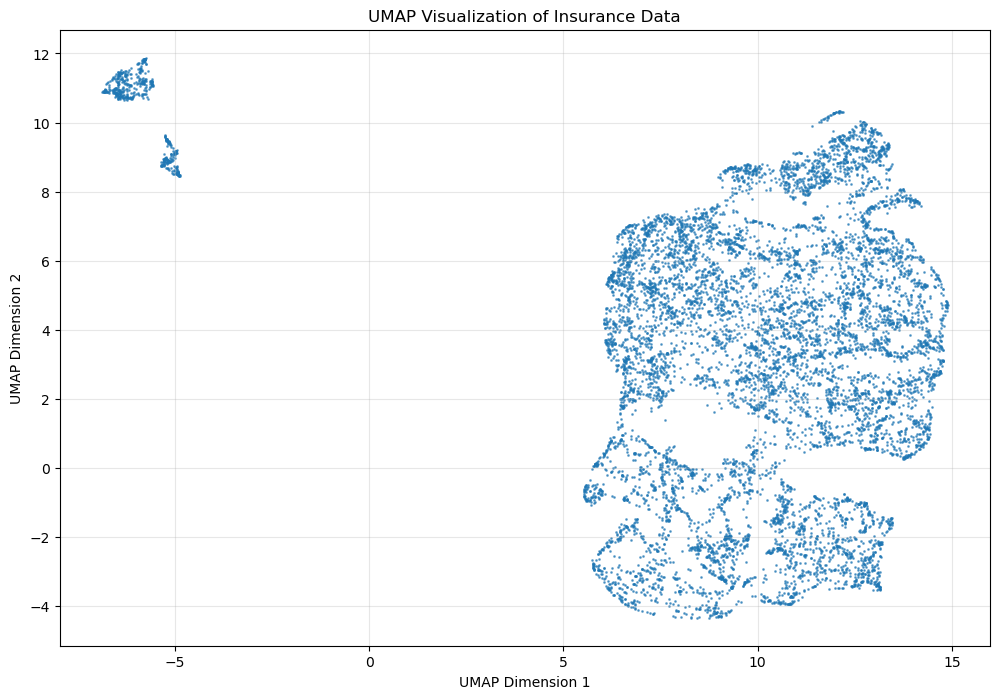

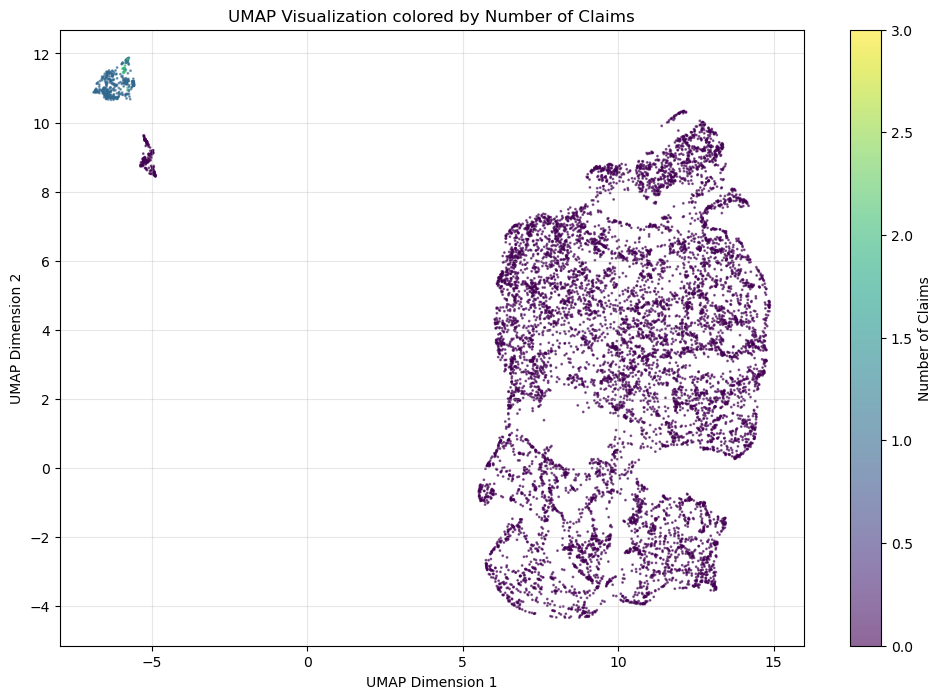

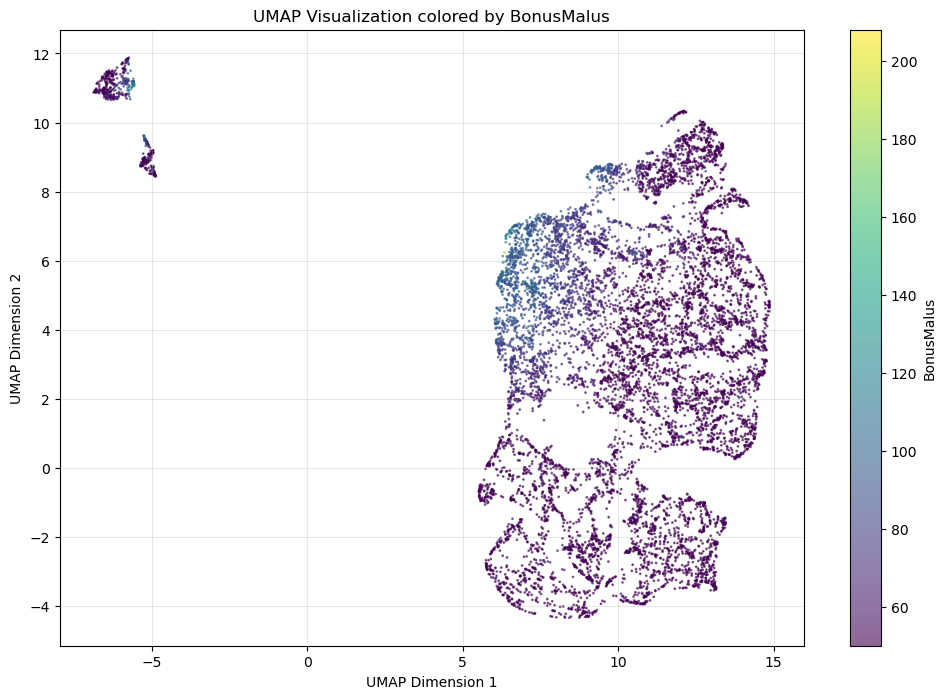

In [52]:
# Create a scatter plot of the UMAP results
plt.figure(figsize=(12, 8))
plt.scatter(umap_data[:, 0], umap_data[:, 1], alpha=0.6, s=1)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization of Insurance Data')
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Color by ClaimNb to see if there are patterns
plt.figure(figsize=(12, 8))
claim_colors = df_sample['ClaimNb'].values
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=claim_colors, alpha=0.6, s=1, cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization colored by Number of Claims')
plt.colorbar(scatter, label='Number of Claims')
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Color by BonusMalus to see if there are patterns
plt.figure(figsize=(12, 8))
bonus_malus_colors = df_sample['BonusMalus'].values
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=bonus_malus_colors, alpha=0.6, s=1, cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization colored by BonusMalus')
plt.colorbar(scatter, label='BonusMalus')
plt.grid(True, alpha=0.3)
plt.show()

UMAP for data >0 claims

In [53]:
# Filter data to only include rows with ClaimNb > 0
df_claims_only = df[df['ClaimNb'] > 0]
print(f"Original data shape: {df.shape}")
print(f"Data with claims > 0 shape: {df_claims_only.shape}")

# Select only numerical columns for UMAP
df_numerical_claims = df_claims_only[numerical_cols]

# Check for missing values and handle them
print("Missing values per column (claims > 0):")
print(df_numerical_claims.isnull().sum())

# Fill any missing values with the median
df_numerical_claims = df_numerical_claims.fillna(df_numerical_claims.median())

# Ensure all data is numeric
df_numerical_claims = df_numerical_claims.astype(float)

# Take a smaller sample for UMAP (adjust sample size based on available data)
available_samples = len(df_numerical_claims)
sample_size_claims = min(10000, available_samples)
df_sample_claims = df_numerical_claims.sample(n=sample_size_claims, random_state=42)
print(f"Sample size for UMAP (claims > 0): {df_sample_claims.shape}")

# Standardize the data
scaler_claims = StandardScaler()
df_standardized_claims = scaler_claims.fit_transform(df_sample_claims)

print(f"Standardized data shape (claims > 0): {df_standardized_claims.shape}")

# Apply UMAP to the standardized sample data
umap_data_claims = umap_model.fit_transform(df_standardized_claims)

print(f"UMAP transformation completed (claims > 0). Output shape: {umap_data_claims.shape}")

Original data shape: (678007, 14)
Data with claims > 0 shape: (24938, 14)
Missing values per column (claims > 0):
Exposure      0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
Density       0
ClaimTotal    0
ClaimNb       0
dtype: int64
Sample size for UMAP (claims > 0): (10000, 8)
Standardized data shape (claims > 0): (10000, 8)
UMAP transformation completed (claims > 0). Output shape: (10000, 2)


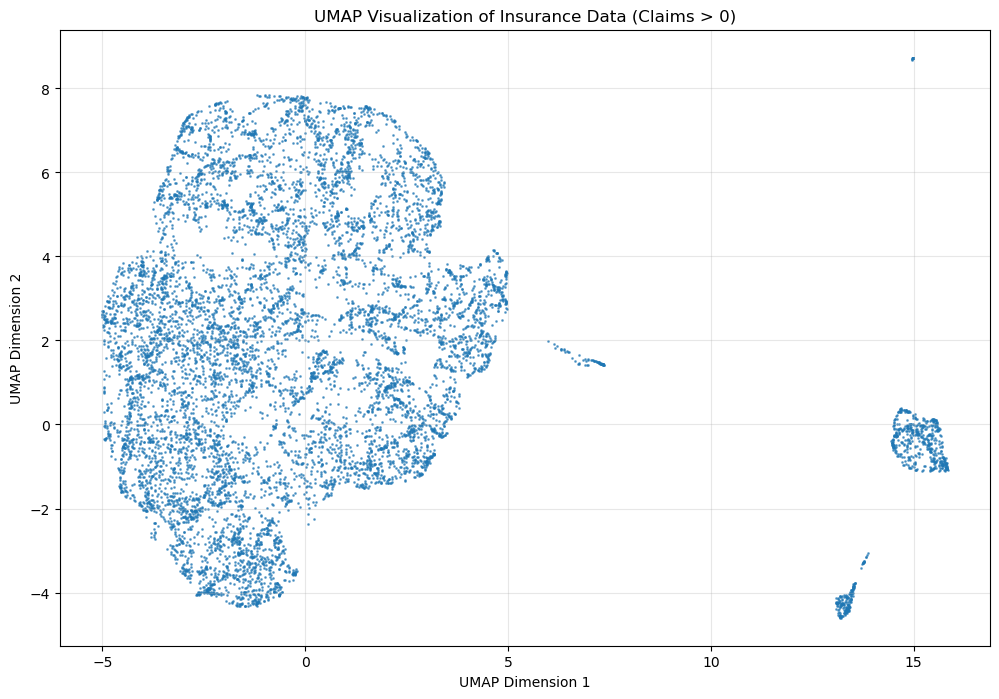

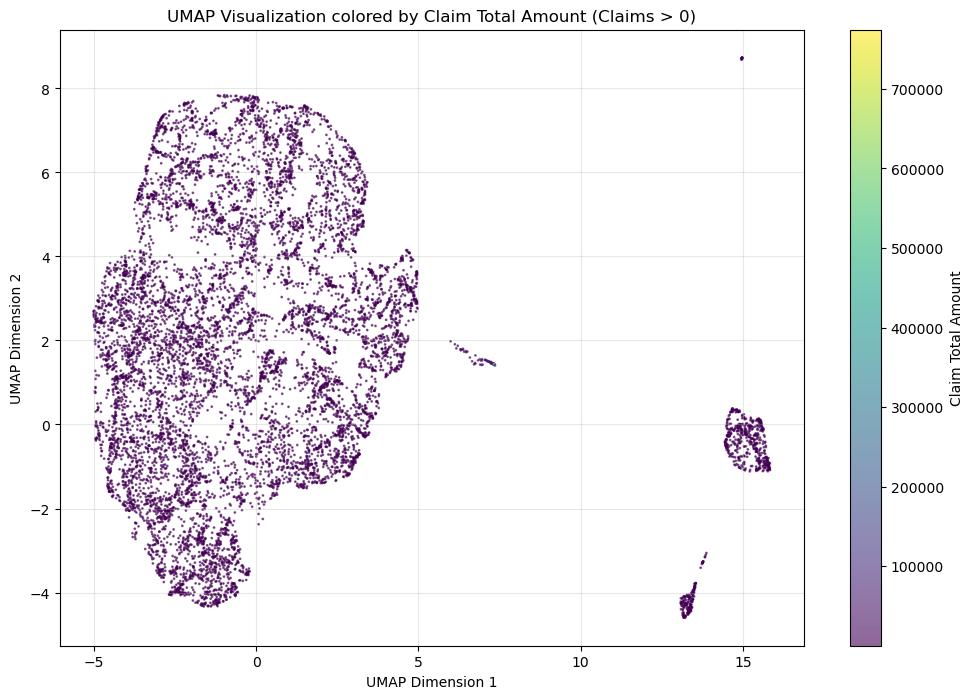

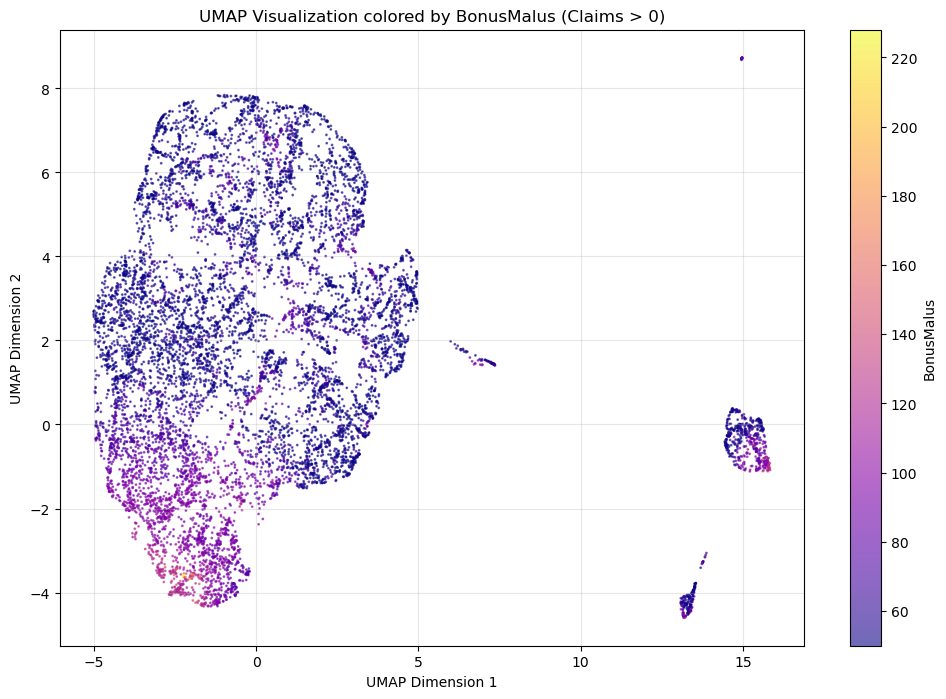

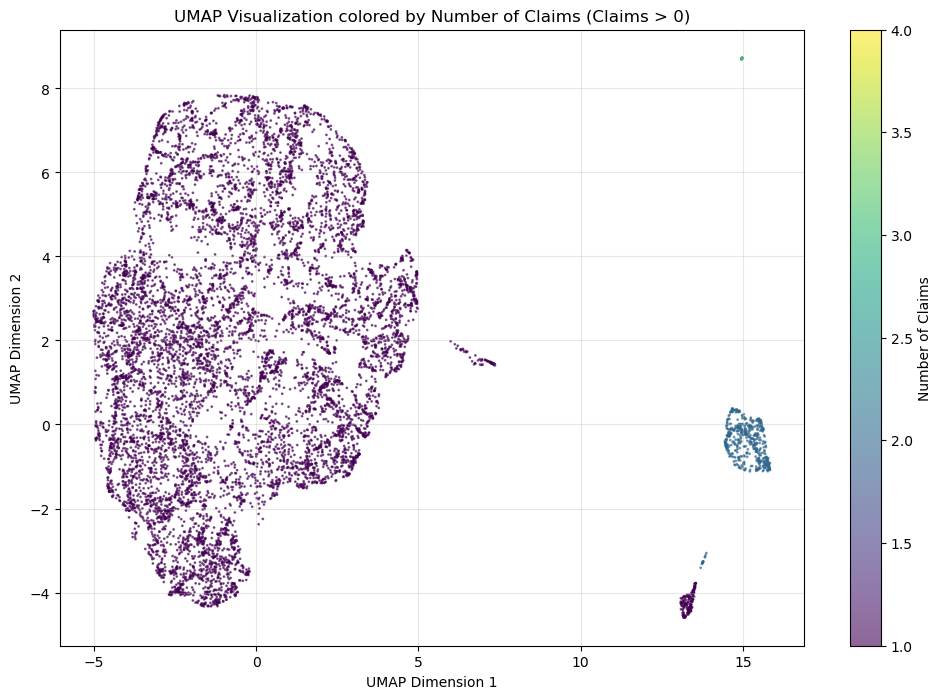

In [54]:
# Create a scatter plot of the UMAP results for claims > 0
plt.figure(figsize=(12, 8))
plt.scatter(umap_data_claims[:, 0], umap_data_claims[:, 1], alpha=0.6, s=1)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization of Insurance Data (Claims > 0)')
plt.grid(True, alpha=0.3)
plt.show()

# Color by ClaimTotal to see patterns in claim amounts
plt.figure(figsize=(12, 8))
claim_total_colors = df_sample_claims['ClaimTotal'].values
scatter = plt.scatter(umap_data_claims[:, 0], umap_data_claims[:, 1], c=claim_total_colors, alpha=0.6, s=1, cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization colored by Claim Total Amount (Claims > 0)')
plt.colorbar(scatter, label='Claim Total Amount')
plt.grid(True, alpha=0.3)
plt.show()

# Color by other variables like BonusMalus
plt.figure(figsize=(12, 8))
bonus_malus_colors = df_sample_claims['BonusMalus'].values
scatter = plt.scatter(umap_data_claims[:, 0], umap_data_claims[:, 1], c=bonus_malus_colors, alpha=0.6, s=1, cmap='plasma')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization colored by BonusMalus (Claims > 0)')
plt.colorbar(scatter, label='BonusMalus')
plt.grid(True, alpha=0.3)
plt.show()

# Color by other variables like NumberofClaims
plt.figure(figsize=(12, 8))
number_of_claims_colors = df_sample_claims['ClaimNb'].values
scatter = plt.scatter(umap_data_claims[:, 0], umap_data_claims[:, 1], c=number_of_claims_colors, alpha=0.6, s=1, cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization colored by Number of Claims (Claims > 0)')
plt.colorbar(scatter, label='Number of Claims')
plt.grid(True, alpha=0.3)
plt.show()

PCA transformation completed. Output shape: (10000, 2)
Explained variance ratio: [0.1990372  0.17688283]
Total explained variance: 0.376


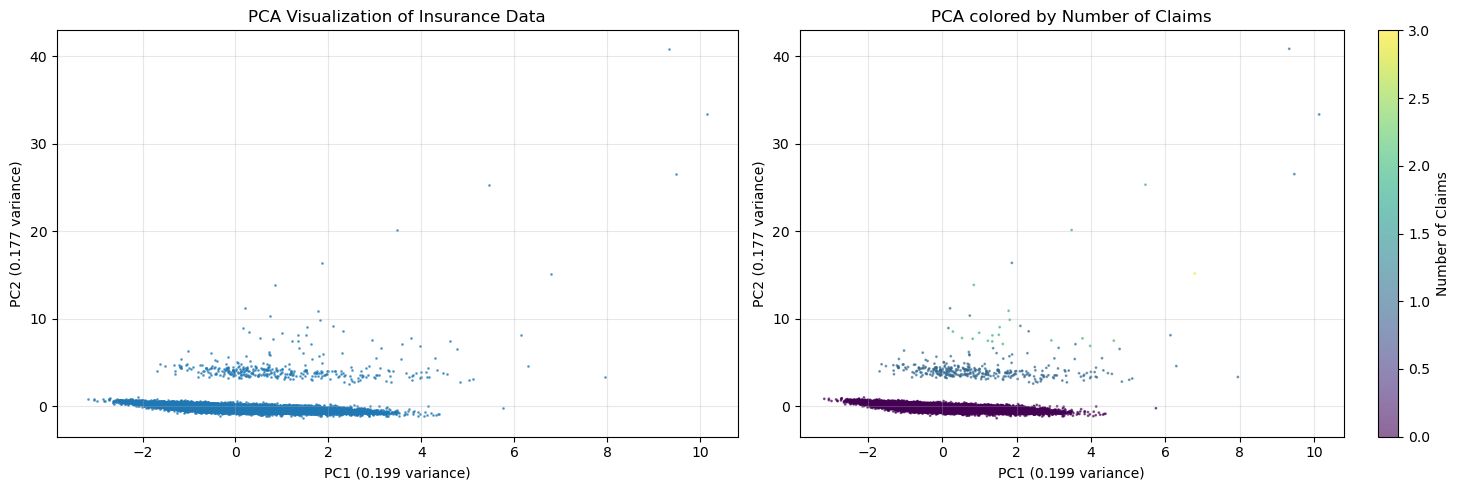

In [57]:
# Create PCA model for 2D visualization
pca_model = PCA(n_components=2, random_state=42)

# Apply PCA to the standardized full dataset sample
pca_data = pca_model.fit_transform(df_standardized)
print(f"PCA transformation completed. Output shape: {pca_data.shape}")
print(f"Explained variance ratio: {pca_model.explained_variance_ratio_}")
print(f"Total explained variance: {pca_model.explained_variance_ratio_.sum():.3f}")

# Create scatter plots for PCA results
plt.figure(figsize=(15, 5))

# Plot 1: Basic PCA visualization
plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.6, s=1)
plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA Visualization of Insurance Data')
plt.grid(True, alpha=0.3)

# Plot 2: Color by Number of Claims
plt.subplot(1, 2, 2)
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=claim_colors, alpha=0.6, s=1, cmap='viridis')
plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA colored by Number of Claims')
plt.colorbar(scatter, label='Number of Claims')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Testing different numbers of clusters...


c:\Company\Miniconda\envs\general_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


k=2: Inertia=69007.60, Silhouette Score=0.539
k=3: Inertia=58875.38, Silhouette Score=0.226
k=4: Inertia=51849.60, Silhouette Score=0.207
k=5: Inertia=44863.36, Silhouette Score=0.224
k=6: Inertia=38295.67, Silhouette Score=0.226
k=7: Inertia=34127.23, Silhouette Score=0.234
k=8: Inertia=31309.22, Silhouette Score=0.219
k=9: Inertia=29358.06, Silhouette Score=0.212
k=10: Inertia=27735.61, Silhouette Score=0.211


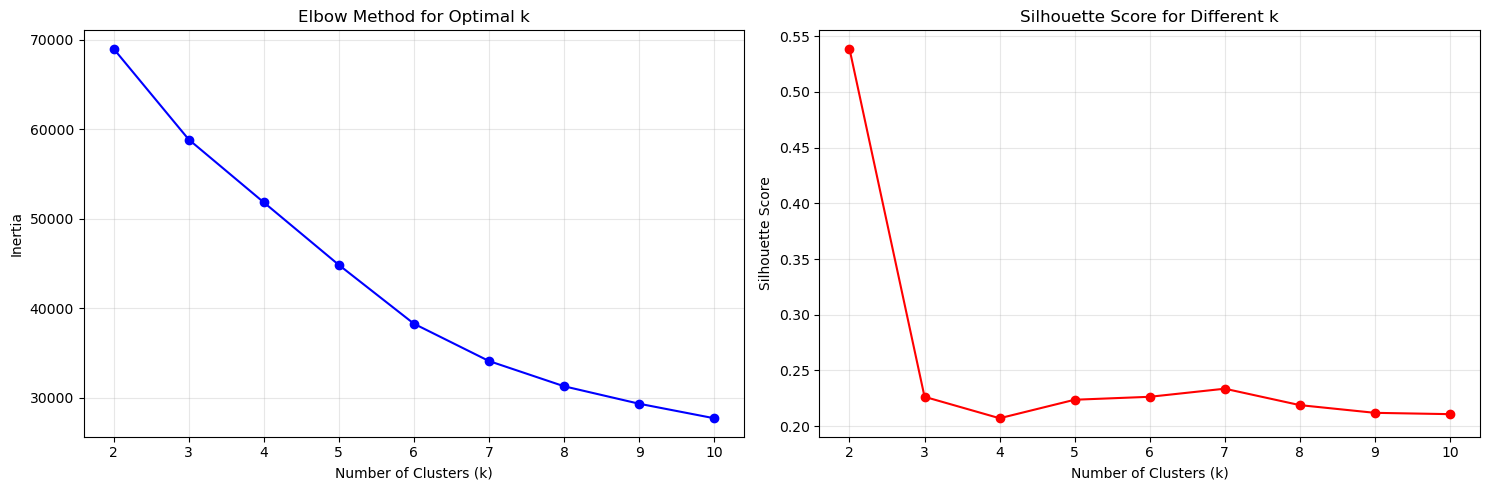


Optimal number of clusters based on silhouette score: 2
Best silhouette score: 0.539


In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Test different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []

# Calculate inertia and silhouette scores for different k values
print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_standardized)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_standardized, kmeans.labels_))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_scores[-1]:.3f}")

# Plot the results
plt.figure(figsize=(15, 5))

# Elbow method plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Prepare the full dataset for linear regression
# First, let's create a copy of the original dataframe
df_regression = df.copy()

# Define target variable (assuming we want to predict ClaimTotal or ClaimNb)
# Let's predict ClaimTotal as the target
target_column = 'ClaimTotal'
X = df_regression.drop([target_column, 'IDpol'], axis=1)  # Remove ID column and target
y = df_regression[target_column]

# Identify categorical and numerical columns
categorical_cols = ['Area', 'VehBrand', 'VehGas', 'Region', 'LearnTest']
numerical_cols = ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimNb']

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Target variable: {target_column}")
print(f"Dataset shape: {X.shape}")

# Create dummy variables for categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"Shape after encoding categorical variables: {X_encoded.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Create and fit the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n=== Linear Regression Results ===")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Categorical columns: ['Area', 'VehBrand', 'VehGas', 'Region', 'LearnTest']
Numerical columns: ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimNb']
Target variable: ClaimTotal
Dataset shape: (678007, 12)
Shape after encoding categorical variables: (678007, 45)
Training set shape: (542405, 45)
Test set shape: (135602, 45)

=== Linear Regression Results ===
Training MSE: 36969093.57
Test MSE: 20434283.75
Training R²: 0.0062
Test R²: 0.0122


Training XGBoost model...
Training completed in 1.37 seconds

=== XGBoost Results ===
Training MSE: 1732743.38
Test MSE: 82532602.11
Training R²: 0.9534
Test R²: -2.9896
Training MAE: 69.44
Test MAE: 130.28

=== Comparison with Linear Regression ===
Linear Regression Test R²: 0.0122
XGBoost Test R²: -2.9896
Improvement: -3.0018

=== Top 15 Most Important Features ===
         feature  importance
7         Area_B    0.456196
17   VehBrand_B2    0.107917
26    Region_R24    0.096323
5        Density    0.088314
8         Area_C    0.053072
1       VehPower    0.047273
0       Exposure    0.042237
2         VehAge    0.034266
10        Area_E    0.013138
6        ClaimNb    0.010062
23    Region_R21    0.008927
19   VehBrand_B4    0.006762
3        DrivAge    0.005633
12  VehBrand_B10    0.005484
4     BonusMalus    0.003179


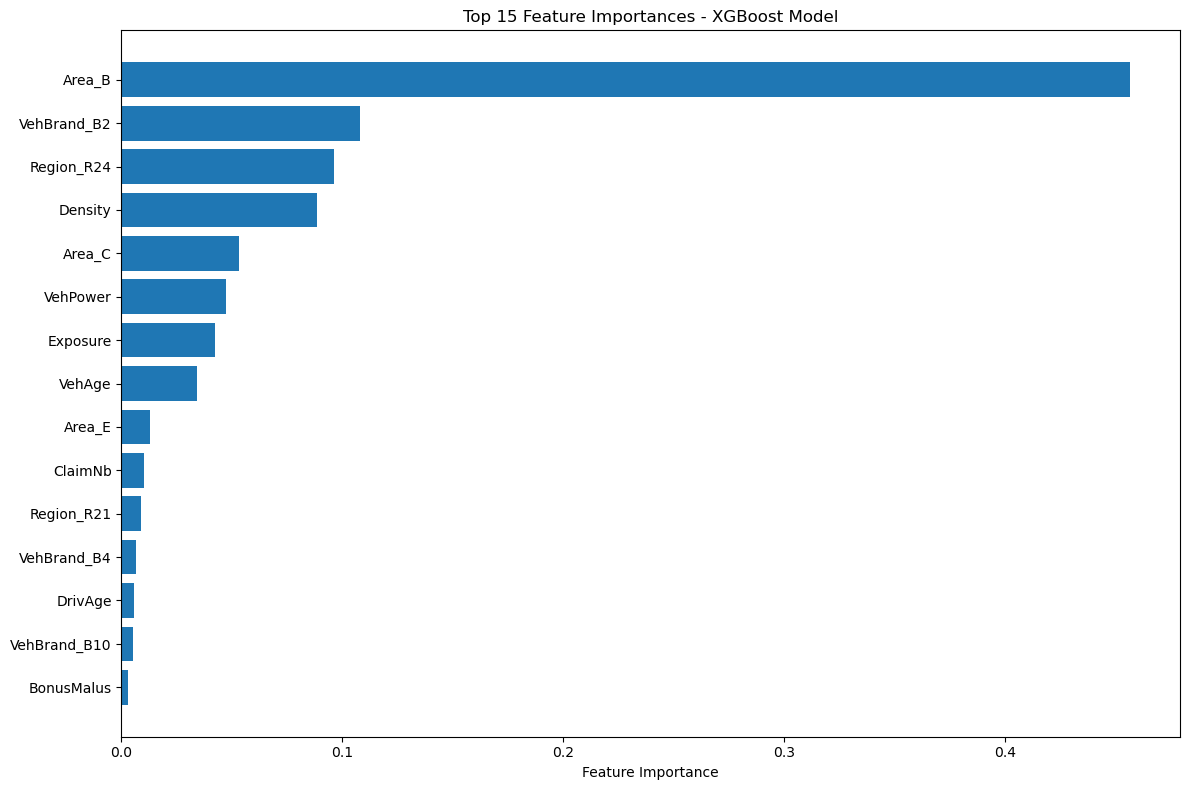

In [63]:
# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,           # Number of trees
    max_depth=6,                # Maximum depth of trees
    learning_rate=0.1,          # Learning rate
    subsample=0.8,              # Subsample ratio
    colsample_bytree=0.8,       # Feature sampling ratio
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

print("Training XGBoost model...")
start_time = time.time()

# Fit the model
xgb_model.fit(X_train, y_train)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate performance metrics
train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

print("\n=== XGBoost Results ===")
print(f"Training MSE: {train_mse_xgb:.2f}")
print(f"Test MSE: {test_mse_xgb:.2f}")
print(f"Training R²: {train_r2_xgb:.4f}")
print(f"Test R²: {test_r2_xgb:.4f}")
print(f"Training MAE: {train_mae_xgb:.2f}")
print(f"Test MAE: {test_mae_xgb:.2f}")

print("\n=== Comparison with Linear Regression ===")
print(f"Linear Regression Test R²: {test_r2:.4f}")
print(f"XGBoost Test R²: {test_r2_xgb:.4f}")
print(f"Improvement: {test_r2_xgb - test_r2:.4f}")

# Feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_encoded.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features ===")
print(importance_df.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()